### Курсовой проект 
Дьяченко Даниил @daniilstv

Построение модели, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по кредиту.
https://geekbrains.ru/lessons/58711

Полезные ссылки:
Про категорирование переменных:
https://dyakonov.org/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/


#### 1. Подгружаем модули, вспомогательные функции

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
# import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:

def df_info(input_dataframe):
    ''' Определение формы датафрейма. '''
    print("Форма: {}\n\nСтолбцы: {}\n\nИндексы: {}\n".format(input_dataframe.shape, 
                                          input_dataframe.columns, input_dataframe.index))
    print('Тип данных:\n',input_dataframe.dtypes)
    #print(input_dataframe.head())
    #print(input_dataframe.describe())
    
    return 


def clean_data_3std(df, columns):
    '''Стандартизация данных в 3 сигма'''
    for i in columns:
        mean = np.round(df[i].mean())
        std3 = 3 * np.round(df[i].std())
        conf_interval = mean + std3
        
        df.loc[ ((df[i] < (mean - std3)) | df[i].isnull() | ( df[i] > (mean + std3) )), i ] = mean
        

def make_dummy(df, column, dict_for_map):
    '''Dummy из словаря dict_for_map = {"Short Term": 0, "Long Term": 1} '''
    for i in column:
#         print(i)
        maper = dict_for_map
        df[i] = df[i].map(maper)
    return 

def dict_from_value_counts(df, column):
    '''Словарь из агрегированных значений для преобразования в dummy'''  
    names = []
    for i in df[column].value_counts().index:
        names.append(i)
    dict_for_map = dict.fromkeys(names)
    return dict_for_map

def balance_df_by_target(df, target_name):
# докинуть  
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def print_scatter(df, col):
    '''Графики зависимости параметра и целевой переменной df[col]'''
    for i in col:
        print("Разброс параметра", i)
        plt.scatter(df[i],df["Credit Default"])
        plt.show()

def find_discrete_col(df, col, n):
    '''Проверка распределения и выявление дискретных значений  df[col]  '''
    #df[col].plot()
   # print(plt.show())
   # df[col].plot(kind="bar")
    #print(plt.show())
   # b = [col]
    discrete_col = []
    for i in col:
        #print('i',i)
        a = df[i].value_counts()
       # print(a, "\n") 
        #print(type(a), 'len - ',len(a))
        if len(a) <= n:
            discrete_col.append(i)
    #print(discrete_col)
    return discrete_col
        
def analyse_data_3std(df, columns):
    for i in columns:
        mean = np.round(df[i].mean())
        std3 = 3 * np.round(df[i].std())
#         conf_interval = mean + std3
        print("Среднее по ", i , "=", mean)
        print("+3 сигма =",mean + std3)
#         df_deviation = df.loc[ ((df[i] < (mean - std3)) | df[i].isnull() | ( df[i] > (mean + std3) )), i ]
        df_deviation = df.loc[ ((df[i] < (mean - std3)) | ( df[i] > (mean + std3) )), i ]
        print("Кол-во выбросов = ",len(df_deviation))
        print("Выбросы:", df_deviation,"\n")
        
        #df.loc[ ((df[i] < (mean - std3)) | df[i].isnull() | ( df[i] > (mean + std3) )), i ] = mean

def del_3std_deviation(df, columns):
    '''Сделать бэкап df перед использованием!'''
    print("Форма на входе = ", df.shape)
    for i in columns:
        mean = np.round(df[i].mean())
        std3 = 3 * np.round(df[i].std())
#         conf_interval = mean + std3
        df= df[(df[i] < (mean - std3)) | ( df[i] < (mean + std3) )]     
    print("Форма на выходе = ", df.shape)    
    return df


In [4]:

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()


#### 2. Подгружаем данные, проводим поверхностный анализ фрейма

In [5]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'


df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_info(df_train)

Форма: (7500, 17)

Столбцы: Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

Индексы: RangeIndex(start=0, stop=7500, step=1)

Тип данных:
 Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount 

Категорийные признаки: Home Ownership, Years in current job, Tax Liens, Number of Credit Problems, Bankruptcies, Purpose, Term

In [7]:
# Привести к категориям  Home Ownership, Years in current job, Tax Liens, 
# Number of Credit Problems, Bankruptcies, Purpose, Term

In [8]:
df_info(df_test)
df_test.head()

Форма: (2500, 16)

Столбцы: Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'],
      dtype='object')

Индексы: RangeIndex(start=0, stop=2500, step=1)

Тип данных:
 Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float6

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [29]:
# Проверить на NaN
len(df_train) - df_train.count()

Home Ownership                    0
Annual Income                     0
Years in current job            371
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                      0
Purpose                           0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
Credit Default                    0
dtype: int64

In [30]:
# Проверить на NaN
len(df_test) - df_test.count()

Home Ownership                   0
Annual Income                    0
Years in current job            86
Tax Liens                        0
Number of Open Accounts          0
Years of Credit History          0
Maximum Open Credit              0
Number of Credit Problems        0
Months since last delinquent     0
Bankruptcies                     0
Purpose                          0
Term                             0
Current Loan Amount              0
Current Credit Balance           0
Monthly Debt                     0
Credit Score                     0
dtype: int64

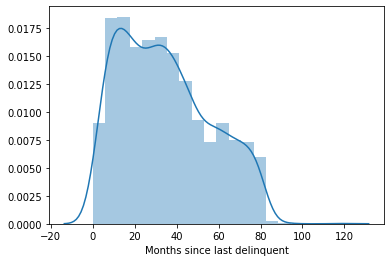

In [11]:
sns.distplot(df_train['Months since last delinquent'].dropna(), bins = 20)

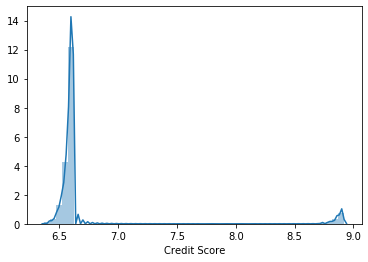

In [12]:
sns.distplot(np.log(df_train['Credit Score'].dropna()))

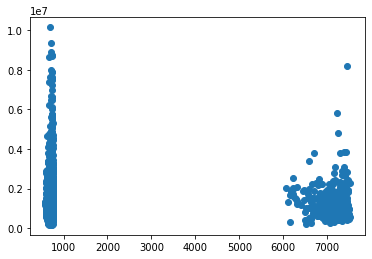

In [13]:
plt.scatter(df_train['Credit Score'], df_train['Annual Income'])
plt.show()
# пропуски соответствуют!
# какой вывод?

In [14]:
TARGET_NAME = 'Credit Score'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
print("Переменные:", BASE_FEATURE_NAMES)


Переменные: ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Default']


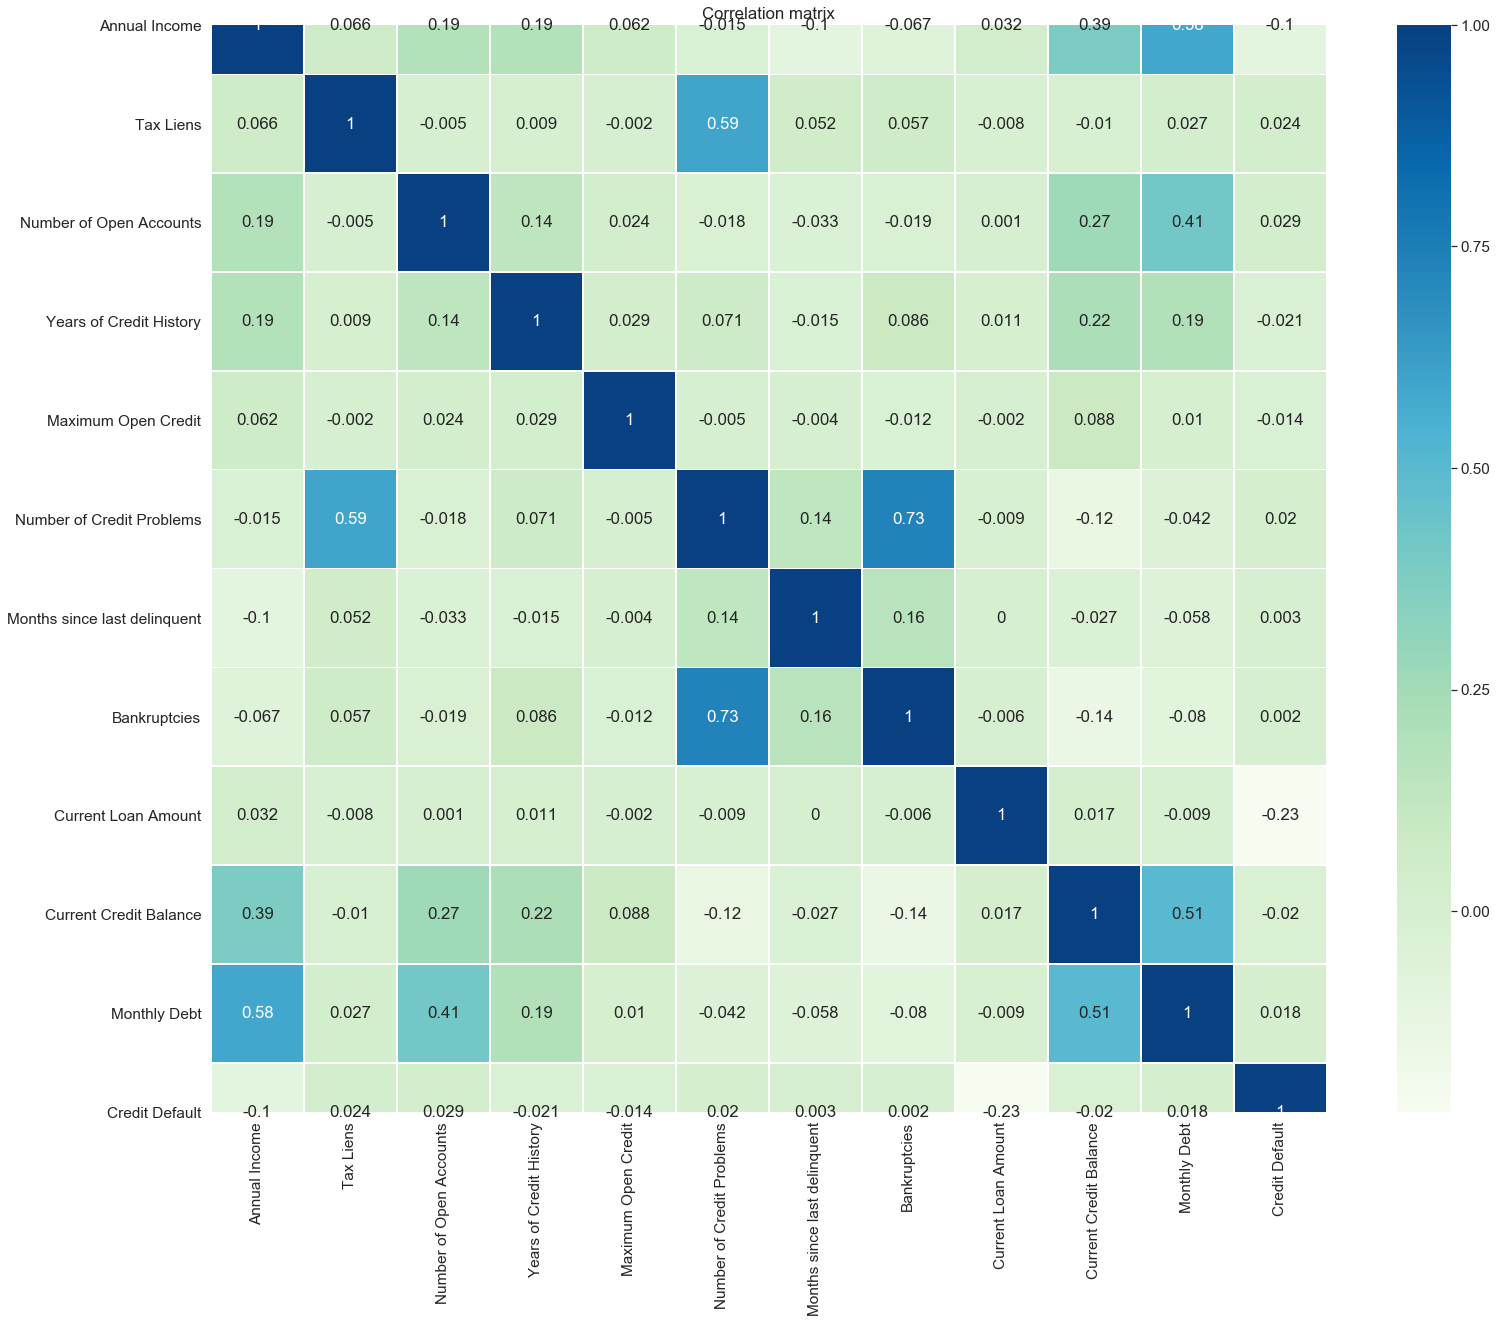

In [15]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

#### Заполнение некоторых пропусков нулями

In [16]:
# Months since last delinquent: NaN -> 0
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0


# Credit Score: NaN -> 0
# df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = 0
# df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = 0
# df_test.loc[df_test['Years in current job'].isnull()]


# Bankruptcies: NaN -> Drop
# df_train = df_train.dropna(subset=['Bankruptcies'])
# df_test = df_test.dropna(subset=['Bankruptcies'])

df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = 0


# Оценить корелляцию Years in current job с Annual Income

# df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = df_test.loc[df_test['Annual Income'].isnull()
# df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train.loc[df_train['Annual Income'].isnull()

In [18]:

col = 'Annual Income'
print(df_test.loc[ (df_test[col].notnull()),col ].mean())
df_test.loc[ (df_test[col].isnull()),col ] = df_test.loc[ (df_test[col].notnull()),col ].mean()

print(df_train.loc[ (df_train[col].notnull()),col ].mean())
df_train.loc[ (df_train[col].isnull()),col ] = df_train.loc[ (df_train[col].notnull()),col ].mean()



col = 'Credit Score'
print(df_test.loc[ (df_test[col].notnull()),col ].mean())
df_test.loc[ (df_test[col].isnull()),col ] = df_test.loc[ (df_test[col].notnull()),col ].mean()

print(df_train.loc[ (df_train[col].notnull()),col ].mean())
df_train.loc[ (df_train[col].isnull()),col ] = df_train.loc[ (df_train[col].notnull()),col ].mean()




1366921.6758933065
1366391.7201749957
1234.5168595873176
1151.0874978966851




#### 3. Вводим фиктивные переменные, цифруем признаки

In [ ]:
'''
Пример
df['IS_MALE'] = df['SEX'].map({'1':'1', '2':'0'}).astype(int)

for cat_colname in df.select_dtypes(include='object').columns[1:]:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    
'''

In [19]:
# Обзор object - признаков
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 40 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************

Te

In [20]:
dict_from_value_counts(df_train, 'Home Ownership')

{'Home Mortgage': None, 'Rent': None, 'Own Home': None, 'Have Mortgage': None}

In [21]:
dict_for_map = {'Home Mortgage': 1, 'Rent': 2, 'Own Home': 0, 'Have Mortgage': 3}

make_dummy(df_train, ['Home Ownership'], dict_for_map)
make_dummy(df_test, ['Home Ownership'], dict_for_map)

In [22]:
dict_from_value_counts(df_train, 'Purpose')

{'debt consolidation': None,
 'other': None,
 'home improvements': None,
 'business loan': None,
 'buy a car': None,
 'medical bills': None,
 'major purchase': None,
 'take a trip': None,
 'buy house': None,
 'small business': None,
 'wedding': None,
 'moving': None,
 'educational expenses': None,
 'vacation': None,
 'renewable energy': None}

In [23]:
dict_for_map = {'debt consolidation': 1,
 'other': 0,
 'home improvements': 2,
 'business loan': 3,
 'buy a car': 4,
 'medical bills': 5,
 'major purchase': 6,
 'take a trip': 7,
 'buy house': 8,
 'small business': 9,
 'wedding': 10,
 'moving': 11,
 'educational expenses': 12,
 'vacation': 13,
 'renewable energy': 14}

make_dummy(df_train, ['Purpose'], dict_for_map)
make_dummy(df_test, ['Purpose'], dict_for_map)

In [24]:
dict_from_value_counts(df_train, 'Term')

{'Short Term': None, 'Long Term': None}

In [25]:
dict_for_map = {'Short Term': 0, 'Long Term': 1}

make_dummy(df_train, ['Term'], dict_for_map)
make_dummy(df_test, ['Term'], dict_for_map)

In [26]:
dict_from_value_counts(df_train, "Years in current job")

{'10+ years': None,
 '2 years': None,
 '3 years': None,
 '< 1 year': None,
 '5 years': None,
 '1 year': None,
 '4 years': None,
 '6 years': None,
 '7 years': None,
 '8 years': None,
 '9 years': None}

In [27]:
dict_for_map = {'10+ years': 10,
 '2 years': 2,
 '3 years': 3,
 '< 1 year': 0,
 '5 years': 5,
 '1 year': 1,
 '4 years': 4,
 '6 years': 6,
 '7 years': 7,
 '8 years': 8,
 '9 years': 9}

make_dummy(df_train, ["Years in current job"], dict_for_map)
make_dummy(df_test, ["Years in current job"], dict_for_map)

In [28]:
# Проверка 
#CAT_FEATURE_NAMES = [ 'Years in current job', 'Home Ownership', 'Purpose', 'Term', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies']
for i in BASE_FEATURE_NAMES:
    print(i)
    print(    df_train[i].value_counts(), "\n") 
    #print(    df_test[i].value_counts(), "\n") 
    
    

Home Ownership
1    3637
2    3204
0     647
3      12
Name: Home Ownership, dtype: int64 

Annual Income
1.366392e+06    1557
1.043651e+06       4
1.058376e+06       4
1.338113e+06       4
1.161660e+06       4
                ... 
1.141254e+06       1
7.907382e+06       1
1.534478e+06       1
9.720400e+05       1
1.654786e+06       1
Name: Annual Income, Length: 5479, dtype: int64 

Years in current job
10.0    2332
2.0      705
3.0      620
0.0      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64 

Tax Liens
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64 

Number of Open Accounts
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0

In [31]:

col = 'Years in current job'
print(df_test.loc[ (df_test[col].notnull()),col ].mean())
df_test.loc[ (df_test[col].isnull()),col ] = df_test.loc[ (df_test[col].notnull()),col ].mean()

print(df_train.loc[ (df_train[col].notnull()),col ].mean())
df_train.loc[ (df_train[col].isnull()),col ] = df_train.loc[ (df_train[col].notnull()),col ].mean()



5.949875724937862
5.880347874877262


In [32]:
# Чекпоинт: Бэкап данных
df_train_ref = df_train.copy()
df_test_ref = df_test.copy()

df_train_ref.to_csv('df_train_ref_2.csv', index=False, encoding='utf-8')
df_test_ref.to_csv('df_test_ref_2.csv', index=False, encoding='utf-8')

In [33]:
# Старт с чекпоинта
df_train = pd.read_csv('df_train_ref_2.csv')
df_test = pd.read_csv('df_test_ref_2.csv')

In [34]:
# Отбор переменных
CAT_FEATURE_NAMES = find_discrete_col(df_train, BASE_FEATURE_NAMES, 15)
NUM_FEATURE_NAMES = list(set(BASE_FEATURE_NAMES).difference(CAT_FEATURE_NAMES))

print("CAT_FEATURE_NAMES",CAT_FEATURE_NAMES)
print("NUM_FEATURE_NAMES",NUM_FEATURE_NAMES)

CAT_FEATURE_NAMES ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'Credit Default']
NUM_FEATURE_NAMES ['Months since last delinquent', 'Number of Open Accounts', 'Annual Income', 'Current Loan Amount', 'Monthly Debt', 'Maximum Open Credit', 'Years of Credit History', 'Current Credit Balance']


#### Анализируем выбросы

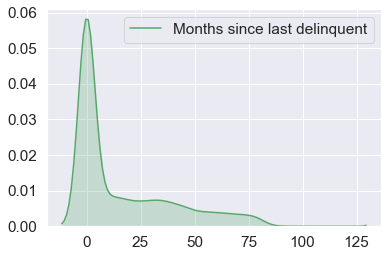

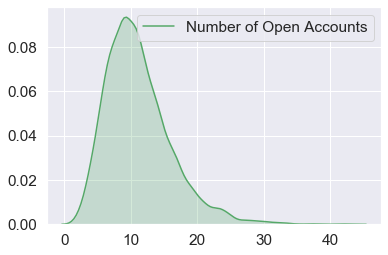

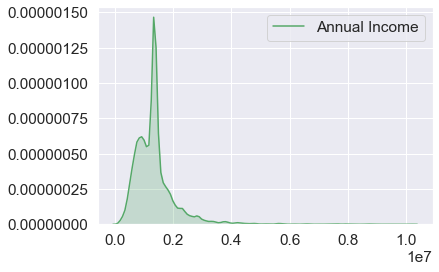

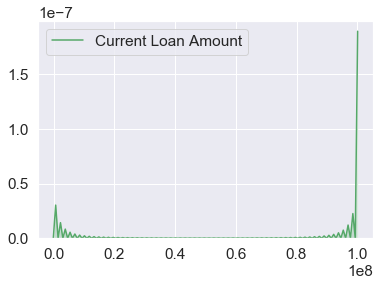

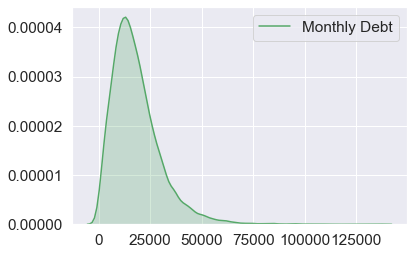

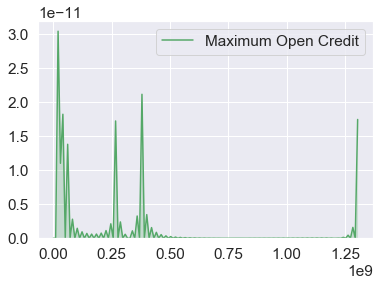

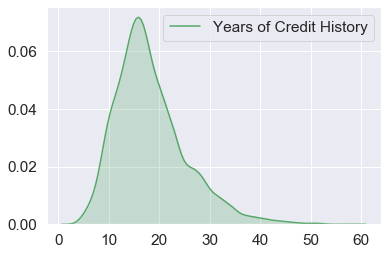

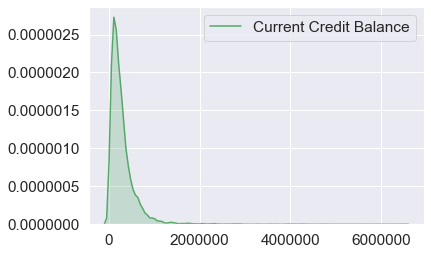

In [35]:
col = NUM_FEATURE_NAMES

for i in col:
   # print(i)
    sns.kdeplot(df_train[i], shade=True, label=i, color='g')
    plt.show()

In [36]:
analyse_data_3std(df_train, NUM_FEATURE_NAMES)
df_train.describe()

Среднее по  Months since last delinquent = 16.0
+3 сигма = 85.0
Кол-во выбросов =  4
Выбросы: 428      86.0
4191    118.0
5202     91.0
5214     92.0
Name: Months since last delinquent, dtype: float64 

Среднее по  Number of Open Accounts = 11.0
+3 сигма = 26.0
Кол-во выбросов =  76
Выбросы: 305     32.0
342     33.0
423     32.0
464     31.0
658     30.0
        ... 
6926    30.0
7089    27.0
7156    28.0
7292    28.0
7478    30.0
Name: Number of Open Accounts, Length: 76, dtype: float64 

Среднее по  Annual Income = 1366392.0
+3 сигма = 3623835.0
Кол-во выбросов =  136
Выбросы: 137     3694037.0
166     4580976.0
307     3705380.0
360     3752880.0
369     4192065.0
          ...    
7299    5289676.0
7357    3853960.0
7410    4655475.0
7478    3888160.0
7486    5327372.0
Name: Annual Income, Length: 136, dtype: float64 

Среднее по  Current Loan Amount = 11873177.0
+3 сигма = 107651546.0
Кол-во выбросов =  0
Выбросы: Series([], Name: Current Loan Amount, dtype: float64) 

Среднее по

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.344133,1.366392e+06,5.880348,0.030133,11.130933,18.317467,9.451537e+05,0.170000,15.815200,0.116933,1.256267,0.259200,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,0.633634,7.524812e+05,3.529408,0.271604,4.908924,7.041946,1.602622e+07,0.498598,22.649441,0.346904,1.355448,0.438225,3.192612e+07,3.178714e+05,11926.764673,1428.207201,0.449874
min,0.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1.000000,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000
50%,1.000000,1.366392e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,1.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,738.000000,0.000000
75%,2.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,29.000000,0.000000,1.000000,1.000000,5.198820e+05,3.604062e+05,23818.000000,1151.087498,1.000000
max,3.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,14.000000,1.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


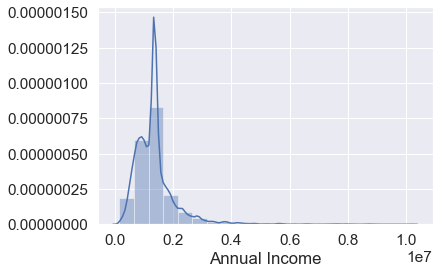

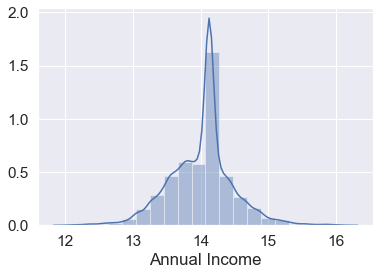

In [37]:
# Пробуем логарифмировать переменную
sns.distplot(df_train['Annual Income'].dropna(), bins = 20)
plt.show()
sns.distplot(np.log(df_train['Annual Income'].dropna()), bins = 20)
plt.show()
# Круто!

In [38]:
# Выполнить логорифмирование
df_train.loc[:, 'Annual Income_lg'] = np.log(df_train['Annual Income'])
df_test.loc[:, 'Annual Income_lg'] = np.log(df_test['Annual Income'])

df_train.loc[:, 'Years of Credit History_lg'] = np.log(df_train['Years of Credit History'])
df_test.loc[:, 'Years of Credit History_lg'] = np.log(df_test['Years of Credit History'])

In [39]:
# Выбрали, что почистить выше 3-сигма и удалили
col = ['Months since last delinquent', 'Maximum Open Credit']
#col = NUM_FEATURE_NAMES
df = df_train.copy()

for i in col:
    mean = np.round(df[i].mean())
    std3 = 3 * np.round(df[i].std())
    conf_interval = mean + std3
    print(mean, std3, conf_interval)
    df_train = df[(df[i] < (mean - std3)) | ( df[i] < (mean + std3) )] 
df_train.describe()

# Сравнить влияние на модель!

16.0 69.0 85.0
945154.0 48078651.0 49023805.0


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_lg,Years of Credit History_lg
count,7496.000000,7.496000e+03,7496.000000,7496.000000,7496.000000,7496.000000,7.496000e+03,7496.000000,7496.00000,7496.000000,7496.000000,7496.000000,7.496000e+03,7.496000e+03,7496.000000,7496.000000,7496.000000,7496.000000,7496.000000
mean,1.343917,1.366152e+06,5.879083,0.030149,11.129669,18.314608,6.778014e+05,0.169957,15.81897,0.116996,1.255870,0.259338,1.187941e+07,2.893793e+05,18314.982524,1151.250953,0.281884,14.015062,2.836819
std,0.633444,7.523779e+05,3.529230,0.271675,4.909698,7.040109,1.079604e+06,0.498627,22.65219,0.346986,1.354027,0.438301,3.193350e+07,3.171892e+05,11927.099527,1428.564868,0.449947,0.468559,0.379588
min,0.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,12.011255,1.386294
25%,1.000000,9.309572e+05,3.000000,0.000000,8.000000,13.500000,2.790975e+05,0.000000,0.00000,0.000000,1.000000,0.000000,1.802350e+05,1.142138e+05,10070.250000,718.000000,0.000000,13.743969,2.602690
50%,1.000000,1.366392e+06,6.000000,0.000000,10.000000,17.000000,4.779170e+05,0.000000,0.00000,0.000000,1.000000,0.000000,3.096060e+05,2.093040e+05,16076.500000,738.000000,0.000000,14.127684,2.833213
75%,2.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.931660e+05,0.000000,29.00000,0.000000,1.000000,1.000000,5.198820e+05,3.592995e+05,23818.000000,1151.087498,1.000000,14.220958,3.081910
max,3.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,4.092389e+07,7.000000,118.00000,4.000000,14.000000,1.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000,16.132920,4.055257


In [40]:
analyse_data_3std(df_train, NUM_FEATURE_NAMES)
df_train.describe()

Среднее по  Months since last delinquent = 16.0
+3 сигма = 85.0
Кол-во выбросов =  4
Выбросы: 428      86.0
4191    118.0
5202     91.0
5214     92.0
Name: Months since last delinquent, dtype: float64 

Среднее по  Number of Open Accounts = 11.0
+3 сигма = 26.0
Кол-во выбросов =  76
Выбросы: 305     32.0
342     33.0
423     32.0
464     31.0
658     30.0
        ... 
6926    30.0
7089    27.0
7156    28.0
7292    28.0
7478    30.0
Name: Number of Open Accounts, Length: 76, dtype: float64 

Среднее по  Annual Income = 1366152.0
+3 сигма = 3623286.0
Кол-во выбросов =  136
Выбросы: 137     3694037.0
166     4580976.0
307     3705380.0
360     3752880.0
369     4192065.0
          ...    
7299    5289676.0
7357    3853960.0
7410    4655475.0
7478    3888160.0
7486    5327372.0
Name: Annual Income, Length: 136, dtype: float64 

Среднее по  Current Loan Amount = 11879409.0
+3 сигма = 107679912.0
Кол-во выбросов =  0
Выбросы: Series([], Name: Current Loan Amount, dtype: float64) 

Среднее по

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_lg,Years of Credit History_lg
count,7496.000000,7.496000e+03,7496.000000,7496.000000,7496.000000,7496.000000,7.496000e+03,7496.000000,7496.00000,7496.000000,7496.000000,7496.000000,7.496000e+03,7.496000e+03,7496.000000,7496.000000,7496.000000,7496.000000,7496.000000
mean,1.343917,1.366152e+06,5.879083,0.030149,11.129669,18.314608,6.778014e+05,0.169957,15.81897,0.116996,1.255870,0.259338,1.187941e+07,2.893793e+05,18314.982524,1151.250953,0.281884,14.015062,2.836819
std,0.633444,7.523779e+05,3.529230,0.271675,4.909698,7.040109,1.079604e+06,0.498627,22.65219,0.346986,1.354027,0.438301,3.193350e+07,3.171892e+05,11927.099527,1428.564868,0.449947,0.468559,0.379588
min,0.000000,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,12.011255,1.386294
25%,1.000000,9.309572e+05,3.000000,0.000000,8.000000,13.500000,2.790975e+05,0.000000,0.00000,0.000000,1.000000,0.000000,1.802350e+05,1.142138e+05,10070.250000,718.000000,0.000000,13.743969,2.602690
50%,1.000000,1.366392e+06,6.000000,0.000000,10.000000,17.000000,4.779170e+05,0.000000,0.00000,0.000000,1.000000,0.000000,3.096060e+05,2.093040e+05,16076.500000,738.000000,0.000000,14.127684,2.833213
75%,2.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.931660e+05,0.000000,29.00000,0.000000,1.000000,1.000000,5.198820e+05,3.592995e+05,23818.000000,1151.087498,1.000000,14.220958,3.081910
max,3.000000,1.014934e+07,10.000000,7.000000,43.000000,57.700000,4.092389e+07,7.000000,118.00000,4.000000,14.000000,1.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000,16.132920,4.055257


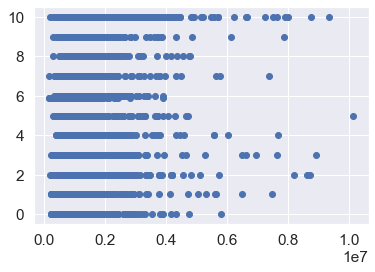

In [41]:
df = df_train[['Annual Income','Years in current job']]

plt.scatter(df_train['Annual Income'], df_train['Years in current job'])
plt.show()

# проверять на выбросы через 3 сигмы или z-score или персентиль 95%

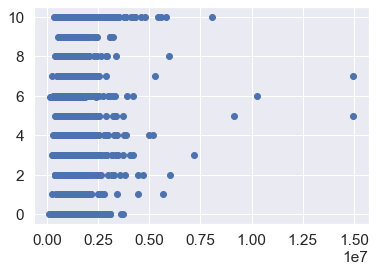

In [42]:
plt.scatter(df_test['Annual Income'], df_test['Years in current job'])
plt.show()

In [43]:
print(df_train.loc[df_train['Annual Income'] > 10000000,['Annual Income', 'Years in current job']])
print(df_test.loc[df_test['Annual Income'] > 8000000,['Annual Income', 'Years in current job']])

      Annual Income  Years in current job
6472     10149344.0                   5.0
      Annual Income  Years in current job
36       14934114.0                   7.0
194      14975610.0                   5.0
860       8057178.0                  10.0
1089     10275770.0                   6.0
1235      9163985.0                   5.0


In [44]:
# Опция - просто удалить выбросы

#df_train = df_train.drop([6472])
#df_test = df_test.drop([36,194,1089])

In [45]:
value = np.round(df_train.loc[ ((df_train['Years in current job'] == 5) & (df_train['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_train.loc[6472,['Annual Income']] = value

value = np.round(df_test.loc[ ((df_test['Years in current job'] == 7) & (df_test['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_test.loc[36,['Annual Income']] = value

value = np.round(df_test.loc[ ((df_test['Years in current job'] == 5) & (df_test['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_test.loc[194,['Annual Income']] = value

value = np.round(df_test.loc[ ((df_test['Years in current job'] == 6) & (df_test['Annual Income'] < 10000000 )),  'Annual Income' ].mean())
df_test.loc[1089,['Annual Income']] = value



In [46]:
print(df_train.loc[df_train['Annual Income'] > 10000000,['Annual Income', 'Years in current job']])
print(df_test.loc[df_test['Annual Income'] > 8000000,['Annual Income', 'Years in current job']])

Empty DataFrame
Columns: [Annual Income, Years in current job]
Index: []
      Annual Income  Years in current job
860       8057178.0                  10.0
1235      9163985.0                   5.0


In [47]:
NUM_FEATURE_NAMES.append('Years of Credit History_lg')
NUM_FEATURE_NAMES.append('Annual Income_lg')
NUM_FEATURE_NAMES

['Months since last delinquent',
 'Number of Open Accounts',
 'Annual Income',
 'Current Loan Amount',
 'Monthly Debt',
 'Maximum Open Credit',
 'Years of Credit History',
 'Current Credit Balance',
 'Years of Credit History_lg',
 'Annual Income_lg']

#### Заполняем пропуски

In [48]:
# Проверить на NaN
print(len(df_train) - df_train.count())

# Проверить на NaN
len(df_test) - df_test.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
Annual Income_lg                0
Years of Credit History_lg      0
dtype: int64


Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Annual Income_lg                0
Years of Credit History_lg      0
dtype: int64

In [49]:
#  Annual Income, Years in current job, Credit Score, Annual Income_lg 

In [98]:
# # Months since last delinquent: NaN -> 0
# df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
# df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0


# # Credit Score: NaN -> 0
# df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = 0
# df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = 0

# df_train.loc[df_train['Years in current job'].isnull()] = 0
# df_test.loc[df_test['Years in current job'].isnull()] = 0

# df_train.loc[df_train['Annual Income'].isnull()] = 0
# df_test.loc[df_test['Annual Income'].isnull()] = 0

# df_train.loc[df_train['Annual Income_lg'].isnull()] = 0
# df_test.loc[df_test['Annual Income_lg'].isnull()] = 0

# df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
# df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

In [339]:
# # Временное решение - заменяем NaN на среднее


# col = 'Annual Income'
# print(df_test.loc[ (df_test[col].notnull()),col ].mean())
# df_test.loc[ (df_test[col].isnull()),col ] = df_test.loc[ (df_test[col].notnull()),col ].mean()

# print(df_train.loc[ (df_train[col].notnull()),col ].mean())
# df_train.loc[ (df_train[col].isnull()),col ] = df_train.loc[ (df_train[col].notnull()),col ].mean()



# col = 'Credit Score'
# print(df_test.loc[ (df_test[col].notnull()),col ].mean())
# df_test.loc[ (df_test[col].isnull()),col ] = df_test.loc[ (df_test[col].notnull()),col ].mean()

# print(df_train.loc[ (df_train[col].notnull()),col ].mean())
# df_train.loc[ (df_train[col].isnull()),col ] = df_train.loc[ (df_train[col].notnull()),col ].mean()



# col = 'Years in current job'
# a = np.round(df_test.loc[ (df_test[col].notnull()),col ].mean())
# print(a)
# df_test.loc[ (df_test[col].isnull()),col ] = a

# a = np.round(df_train.loc[ (df_train[col].notnull()),col ].mean())
# print(a)
# df_train.loc[ (df_train[col].isnull()),col ] = a

1347815.1546599497
1366372.539369415
1235.0100755667506
1148.6487944697353
6.0
6.0


##### Years in current job

In [277]:
# Делаем общий тренировочный сет и сеты для предсказаний
df_big = pd.concat([df_train, df_test])
# df_info(df_big)
# len(df_big) - df_big.count()

df_big_train = df_big.dropna()

df_big_test = df_big.drop(['Credit Default'], axis = 1 )

df_big_test_inc = df_big_test[df_big_test['Annual Income'].isnull()]
df_big_test_years = df_big_test[df_big_test['Years in current job'].isnull()]
df_big_test_score = df_big_test[df_big_test['Credit Score'].isnull()]

In [278]:
TARGET_NAME = 'Years in current job'
BASE_FEATURE_NAMES = df_big_train.columns.drop(TARGET_NAME).tolist()
print("Переменные:", BASE_FEATURE_NAMES)
df_big_train[TARGET_NAME].value_counts()

Переменные: ['Annual Income', 'Bankruptcies', 'Credit Default', 'Credit Score', 'Current Credit Balance', 'Current Loan Amount', 'Home Ownership', 'Maximum Open Credit', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Number of Open Accounts', 'Purpose', 'Tax Liens', 'Term', 'Years of Credit History']


10.0    1858
2.0      558
3.0      490
0.0      442
5.0      396
1.0      395
4.0      370
6.0      350
7.0      308
8.0      279
9.0      189
Name: Years in current job, dtype: int64

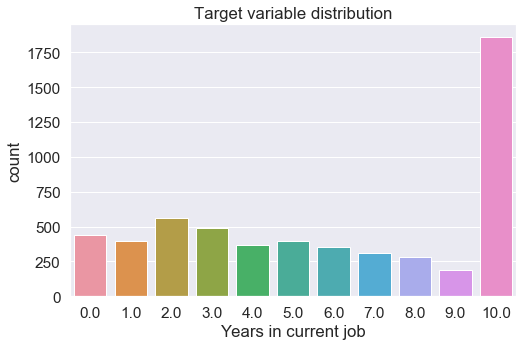

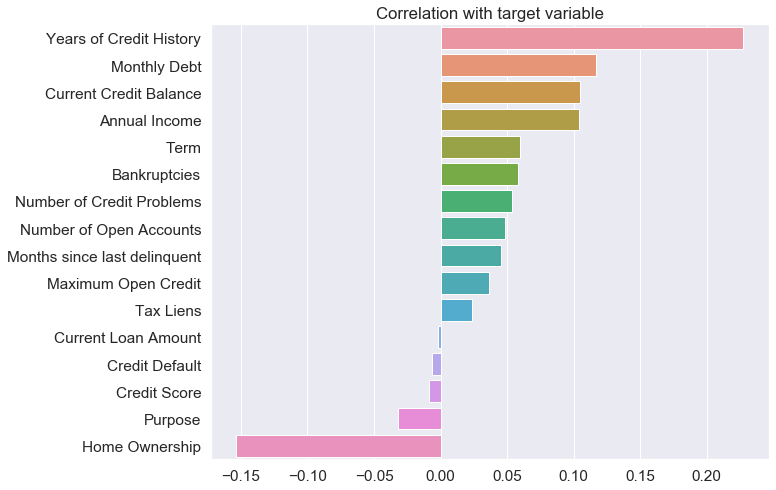

In [279]:
# Обзор распределения целевой переменной
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_big_train)

plt.title('Target variable distribution')
plt.show()
# Корреляция с базовыми признаками
corr_with_target = df_big_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [280]:
SELECTED_FEATURE_NAMES = ['Annual Income', 'Current Credit Balance', 'Home Ownership', 'Monthly Debt', 
                          'Years of Credit History']

In [295]:
SELECTED_FEATURE_NAMES = [ 'Home Ownership', 
                          'Years of Credit History']

In [296]:
# Разбиение на train и test
X = df_big_train[SELECTED_FEATURE_NAMES]
y = df_big_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [276]:
# Балансировка целевой переменной!!!
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
# df_balanced[TARGET_NAME].value_counts()

10.0    1313
9.0     1206
2.0      384
3.0      334
0.0      309
1.0      288
5.0      266
6.0      258
4.0      254
7.0      225
8.0      179
Name: Years in current job, dtype: int64

In [297]:
# Нормализация данных

scaler = StandardScaler()

df_norm = df_big_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_big_train[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [298]:
# Сохранение модели для нормализации данных
SCALER_FILE_PATH = '../scaler_Years in current job.pkl'

with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [307]:
y_train

4587    10.0
2187     2.0
3329     8.0
4832    10.0
953      8.0
        ... 
6287    10.0
1564     4.0
77       3.0
1059     1.0
7105     5.0
Name: Years in current job, Length: 3944, dtype: category
Categories (11, float64): [0.0, 1.0, 2.0, 3.0, ..., 7.0, 8.0, 9.0, 10.0]

In [308]:
# Приведение типов для модели CatBoost
CAT_FEATURE_NAMES = ['Years of Credit History', 'Home Ownership' ]
for colname in CAT_FEATURE_NAMES:
    X_train[colname] = pd.Categorical(X_train[colname])
     
X_train[CAT_FEATURE_NAMES].dtypes


Years of Credit History    category
Home Ownership             category
dtype: object

In [309]:
# CatBoost
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

CatBoostError: features data: pandas.DataFrame column 'Home Ownership' has dtype 'category' but is not in  cat_features list

In [288]:
# XGBoost
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.61      0.26      0.37       309
         1.0       0.41      0.18      0.25       288
         2.0       0.45      0.24      0.31       384
         3.0       0.53      0.11      0.18       334
         4.0       0.60      0.11      0.18       254
         5.0       0.64      0.07      0.12       266
         6.0       0.85      0.04      0.08       258
         7.0       0.64      0.03      0.06       225
         8.0       1.00      0.02      0.04       179
         9.0       1.00      0.03      0.06       134
        10.0       0.39      0.97      0.55      1313

    accuracy                           0.41      3944
   macro avg       0.65      0.19      0.20      3944
weighted avg       0.55      0.41      0.31      3944

TEST

              precision    recall  f1-score   support

         0.0       0.16      0.08      0.10       133
         1.0       0.12      0.07      0.08       107
         2.

##### Annual Income

In [310]:
TARGET_NAME = 'Annual Income'
BASE_FEATURE_NAMES = df_big_train.columns.drop(TARGET_NAME).tolist()
print("Переменные:", BASE_FEATURE_NAMES)
df_big_train[TARGET_NAME].value_counts()


Переменные: ['Bankruptcies', 'Credit Default', 'Credit Score', 'Current Credit Balance', 'Current Loan Amount', 'Home Ownership', 'Maximum Open Credit', 'Monthly Debt', 'Months since last delinquent', 'Number of Credit Problems', 'Number of Open Accounts', 'Purpose', 'Tax Liens', 'Term', 'Years in current job', 'Years of Credit History']


1161660.0    4
1058376.0    4
969475.0     4
1338113.0    4
1043651.0    4
            ..
653429.0     1
1206842.0    1
1671905.0    1
1766468.0    1
1654786.0    1
Name: Annual Income, Length: 5200, dtype: int64

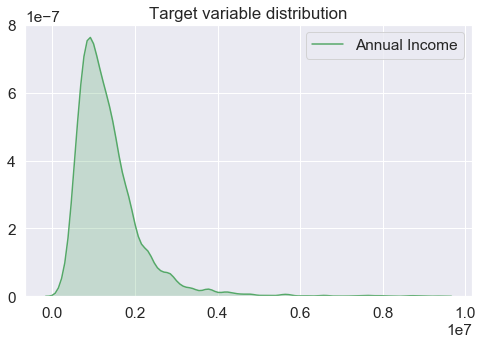

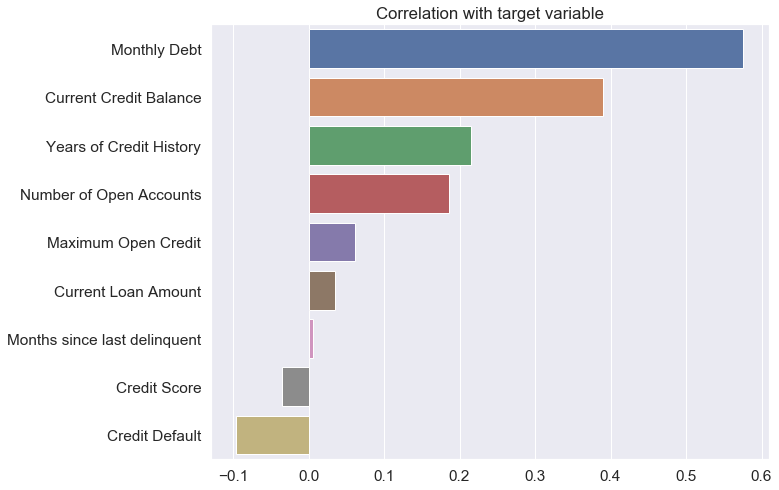

In [314]:
# Обзор распределения целевой переменной
plt.figure(figsize=(8, 5))

#sns.countplot(x=TARGET_NAME, data=df_big_train)

plt.title('Target variable distribution')
sns.kdeplot(df_train[TARGET_NAME], shade=True, label=TARGET_NAME, color='g')
plt.show()
# Корреляция с базовыми признаками
corr_with_target = df_big_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [315]:
SELECTED_FEATURE_NAMES = ['Number of Open Accounts', 'Current Credit Balance', 'Home Ownership', 'Monthly Debt', 
                          'Years of Credit History']



In [316]:
# Разбиение на train и test
X = df_big_train[SELECTED_FEATURE_NAMES]
y = df_big_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [317]:
# Нормализация данных

scaler = StandardScaler()

df_norm = df_big_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_big_train[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [318]:
# Сохранение модели для нормализации данных
SCALER_FILE_PATH = '../scaler_Annual Income.pkl'

with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [319]:
# XGBoost
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Home Ownership

In [323]:
# Логистическая регрессия
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

    191577.0       0.00      0.00      0.00         1
    226252.0       0.00      0.00      0.00         1
    245518.0       0.00      0.00      0.00         1
    260604.0       0.00      0.00      0.00         1
    269800.0       0.00      0.00      0.00         1
    282929.0       0.00      0.00      0.00         1
    287964.0       0.00      0.00      0.00         1
    289997.0       0.00      0.00      0.00         1
    291745.0       0.00      0.00      0.00         1
    299136.0       0.00      0.00      0.00         1
    305577.0       0.00      0.00      0.00         1
    306793.0       0.00      0.00      0.00         1
    315419.0       0.00      0.00      0.00         1
    316198.0       0.00      0.00      0.00         1
    325926.0       0.00      0.00      0.00         1
    334039.0       0.00      0.00      0.00         1
    336661.0       0.00      0.00      0.00         1
    342038.0       0

In [320]:
# knn ближайших соседей
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

    191577.0       0.25      1.00      0.40         1
    226252.0       0.25      1.00      0.40         1
    245518.0       0.25      1.00      0.40         1
    260604.0       0.25      1.00      0.40         1
    269800.0       0.50      1.00      0.67         1
    282929.0       0.12      1.00      0.22         1
    287964.0       0.33      1.00      0.50         1
    289997.0       0.14      1.00      0.25         1
    291745.0       0.17      1.00      0.29         1
    299136.0       0.20      1.00      0.33         1
    305577.0       0.25      1.00      0.40         1
    306793.0       0.20      1.00      0.33         1
    315419.0       0.17      1.00      0.29         1
    316198.0       0.14      1.00      0.25         1
    325926.0       0.33      1.00      0.50         1
    334039.0       0.14      1.00      0.25         1
    336661.0       0.33      1.00      0.50         1
    342038.0       0

col_0          191577.0   226252.0   245518.0   260604.0   269800.0   \
Annual Income                                                          
164597.0               0          0          0          0          0   
192223.0               0          0          0          0          0   
225112.0               0          0          0          0          0   
233453.0               0          0          0          0          0   
244416.0               0          0          0          0          0   
...                  ...        ...        ...        ...        ...   
7476880.0              0          0          0          0          0   
7655480.0              0          0          0          0          0   
8710740.0              0          0          0          0          0   
8923844.0              0          0          0          0          0   
9338880.0              0          0          0          0          0   

col_0          282929.0   287964.0   289997.0   291745.0   2991

In [321]:
# Приведение типов для модели CatBoost
CAT_FEATURE_NAMES = ['Years of Credit History', 'Home Ownership' ]
for colname in CAT_FEATURE_NAMES:
    X_train[colname] = pd.Categorical(X_train[colname])
     
X_train[CAT_FEATURE_NAMES].dtypes


Years of Credit History    category
Home Ownership             category
dtype: object

In [322]:
# CatBoost
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

CatBoostError: features data: pandas.DataFrame column 'Home Ownership' has dtype 'category' but is not in  cat_features list

### Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

In [50]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_test.columns.drop(BASE_FEATURE_NAMES)

print("Переменные:", BASE_FEATURE_NAMES)
print("\nНовые переменные:", *NEW_FEATURE_NAMES)

df_train[TARGET_NAME].value_counts()
# Целевая переменная требует балансировки


Переменные: ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Annual Income_lg', 'Years of Credit History_lg']

Новые переменные:


0    5383
1    2113
Name: Credit Default, dtype: int64

In [51]:
5909/1467

4.0279481935923656

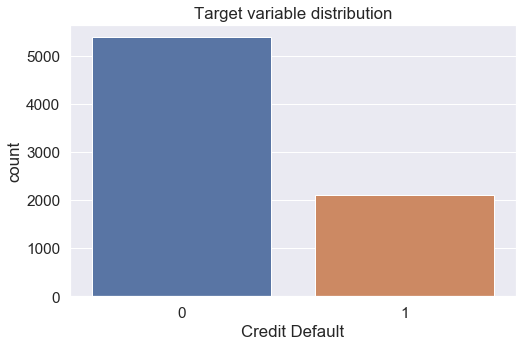

In [52]:
# Обзор распределения целевой переменной
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

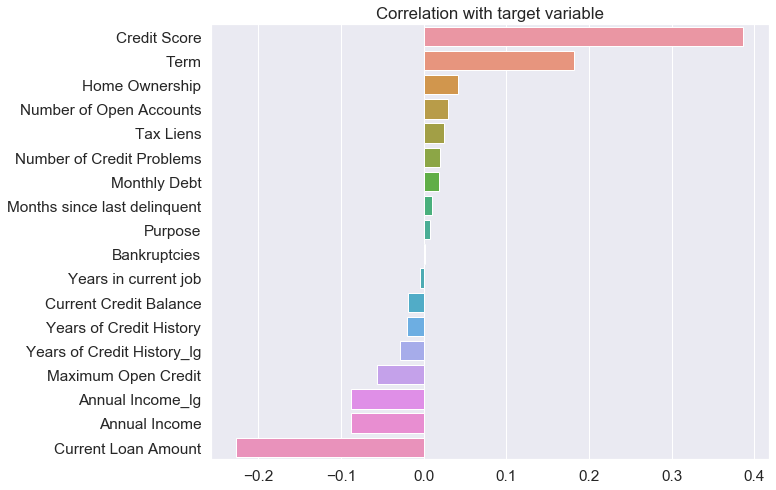

In [53]:
# Корреляция с базовыми признаками
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [344]:
# Потренироваться проверить гипотезы - Нулевая гипотеза: признаки 1 и 2 согласованы

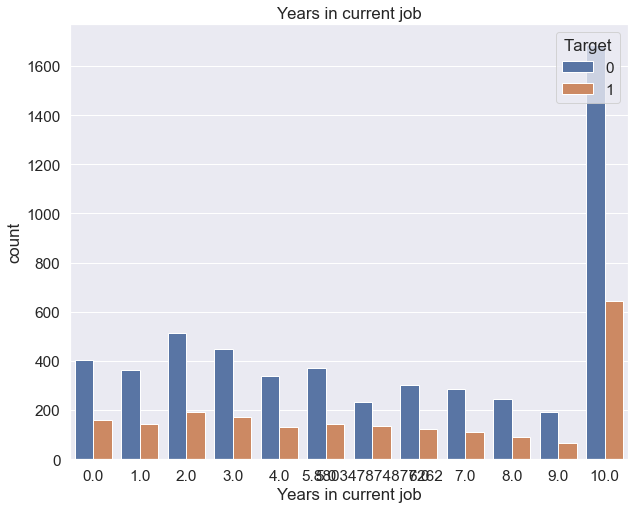

In [54]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('Years in current job')
plt.legend(title='Target', loc='upper right')

plt.show()



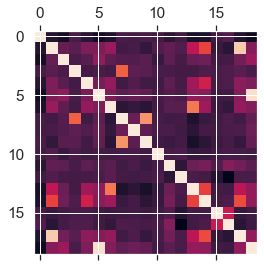

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income_lg,Years of Credit History_lg
Home Ownership,1,-0.104443,-0.150529,0.00796607,-0.0910048,-0.162427,-0.117223,0.00585053,-0.000588637,0.0111602,-0.00632069,-0.0848545,-0.0166195,-0.142835,-0.130481,-5.95032e-05,0.0413369,-0.116358,-0.175601
Annual Income,-0.104443,1,0.0925982,0.0592404,0.169533,0.167133,0.240497,-0.0131802,0.00551925,-0.059711,0.0350419,0.088191,0.0325035,0.350644,0.518183,-0.0375985,-0.088369,0.896835,0.186742
Years in current job,-0.150529,0.0925982,1,0.0168512,0.0538399,0.218571,0.0794039,0.0470569,0.0356877,0.0555695,-0.0369202,0.0705452,-0.00116906,0.106567,0.122688,-0.00835219,-0.00402422,0.134642,0.247856
Tax Liens,0.00796607,0.0592404,0.0168512,1,-0.00533204,0.00915924,-0.00829542,0.595475,0.0706764,0.0574054,0.00840507,0.00491842,-0.00785713,-0.010061,0.0272128,0.00932631,0.0243338,0.0533831,0.0126802
Number of Open Accounts,-0.0910048,0.169533,0.0538399,-0.00533204,1,0.14486,0.23043,-0.0180504,0.0339243,-0.0187744,-0.018338,0.0714828,0.00144048,0.267518,0.413902,0.0143701,0.0290513,0.20856,0.161279
Years of Credit History,-0.162427,0.167133,0.218571,0.00915924,0.14486,1,0.165865,0.0715607,0.0977461,0.0857771,0.000297879,0.0445104,0.0107769,0.216595,0.192304,-0.013906,-0.0203257,0.188418,0.964528
Maximum Open Credit,-0.117223,0.240497,0.0794039,-0.00829542,0.23043,0.165865,1,-0.0800825,-0.0532567,-0.0892143,-0.010827,0.0571118,0.0546606,0.657823,0.261655,-0.0213652,-0.0568197,0.231638,0.173415
Number of Credit Problems,0.00585053,-0.0131802,0.0470569,0.595475,-0.0180504,0.0715607,-0.0800825,1,0.108647,0.731012,0.0077114,-0.0203886,-0.00856584,-0.124284,-0.0426458,-0.0163956,0.0201482,-0.0119569,0.0811033
Months since last delinquent,-0.000588637,0.00551925,0.0356877,0.0706764,0.0339243,0.0977461,-0.0532567,0.108647,1,0.0675898,0.00889237,0.00920422,-0.0162255,-0.0818942,-0.00314121,-0.00248141,0.0100079,0.0212902,0.11731
Bankruptcies,0.0111602,-0.059711,0.0555695,0.0574054,-0.0187744,0.0857771,-0.0892143,0.731012,0.0675898,1,-0.0157319,-0.0310909,-0.00623475,-0.14242,-0.0788829,-0.0252208,0.00152801,-0.053647,0.0942495


In [55]:
X_corr = df_train.corr()
plt.matshow(X_corr)
plt.show()
X_corr.style.background_gradient(cmap='coolwarm')

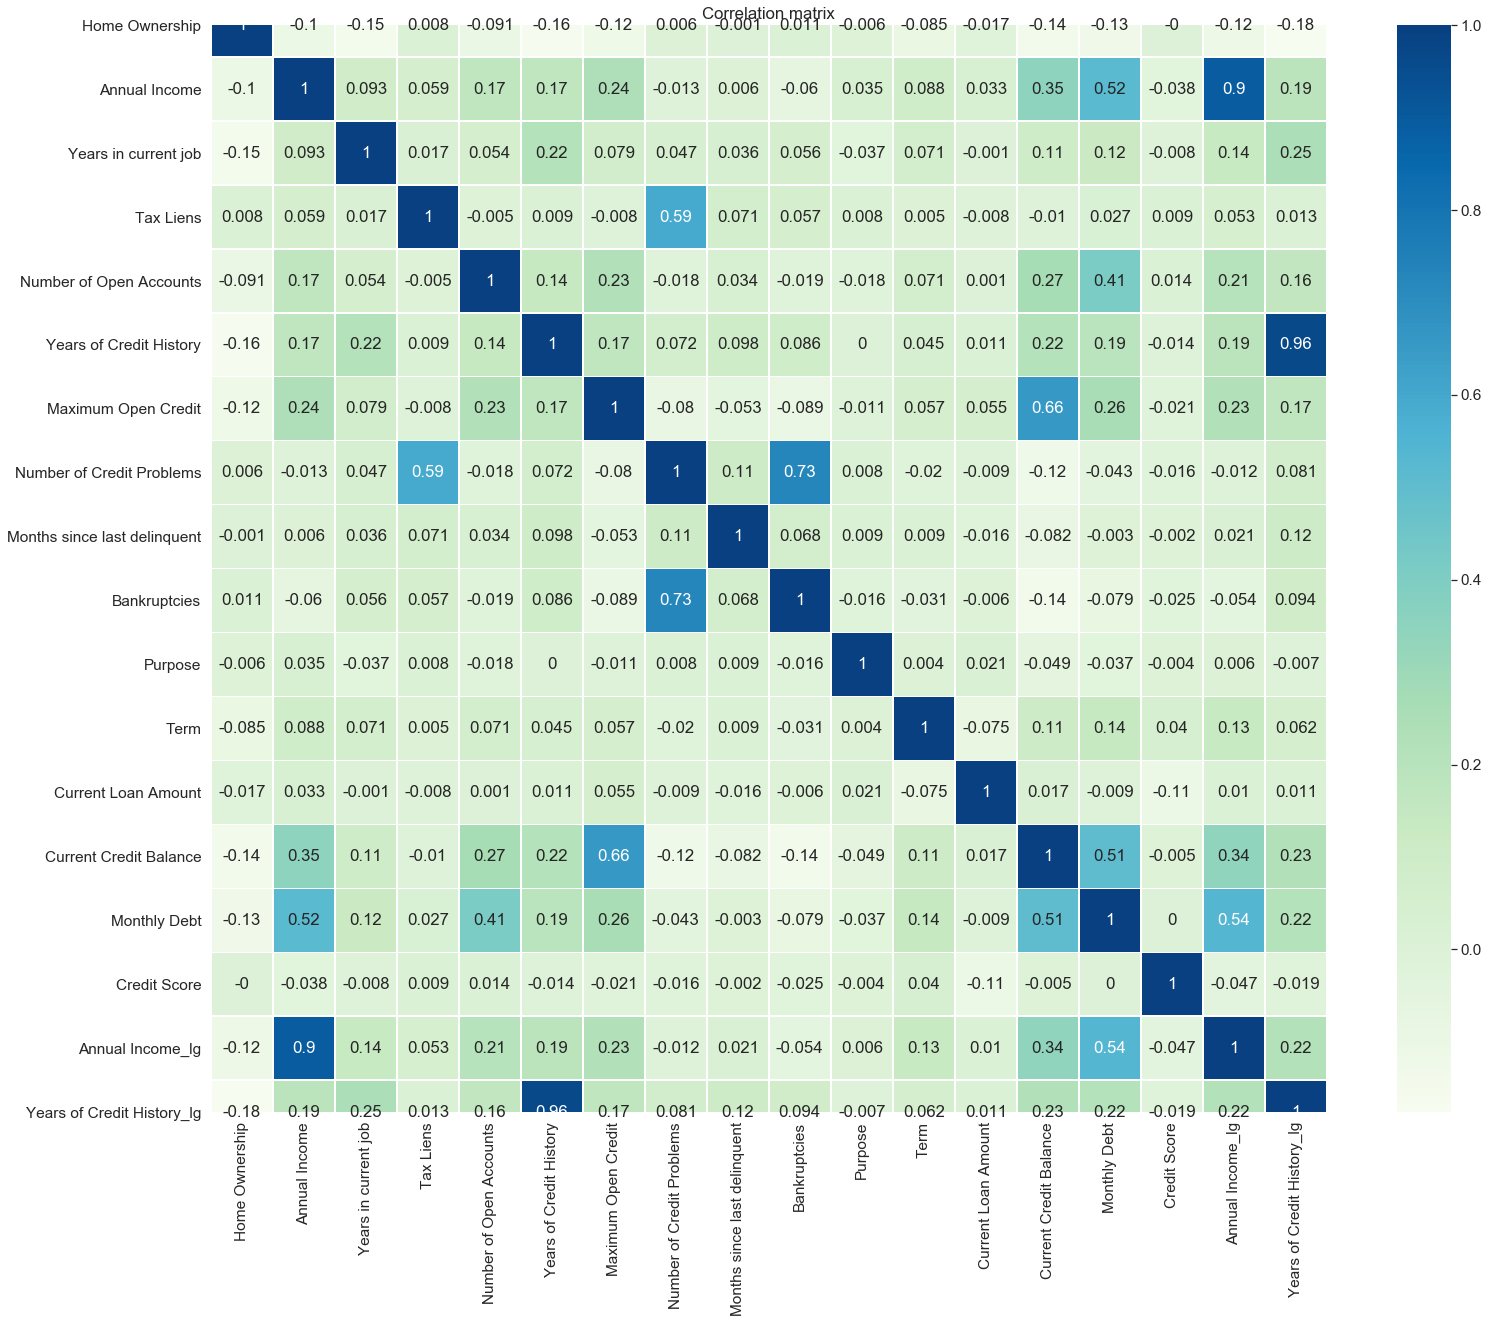

In [56]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# Убрать кореллирующие мду собой

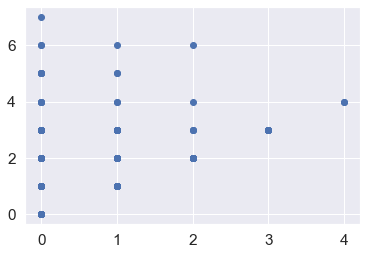

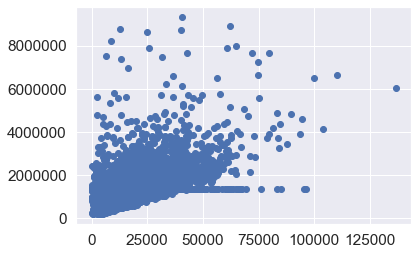

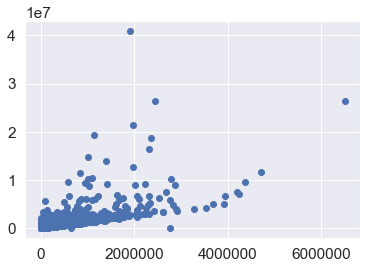

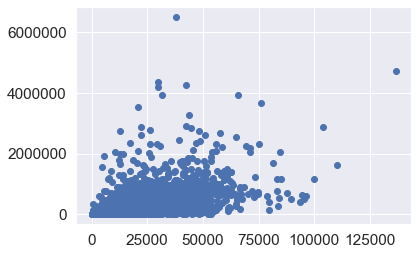

In [102]:
# Зависимость кореллирующих признаков
plt.scatter(df_train['Bankruptcies'], df_train['Number of Credit Problems'])
plt.show()

plt.scatter(df_train['Monthly Debt'], df_train['Annual Income'])
plt.show()

plt.scatter(df_train['Current Credit Balance'], df_train['Maximum Open Credit'])
plt.show()

plt.scatter(df_train['Monthly Debt'], df_train['Current Credit Balance'])
plt.show()

In [57]:
# Обзор признаков
print('BASE_FEATURE_NAMES:',BASE_FEATURE_NAMES)
print('\nCAT_FEATURE_NAMES:', CAT_FEATURE_NAMES)
NUM_FEATURE_NAMES = list(set(BASE_FEATURE_NAMES).difference(CAT_FEATURE_NAMES))
print('\nNUM_FEATURE_NAMES:',NUM_FEATURE_NAMES)



BASE_FEATURE_NAMES: ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Annual Income_lg', 'Years of Credit History_lg']

CAT_FEATURE_NAMES: ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'Credit Default']

NUM_FEATURE_NAMES: ['Months since last delinquent', 'Number of Open Accounts', 'Annual Income', 'Current Loan Amount', 'Monthly Debt', 'Years of Credit History_lg', 'Maximum Open Credit', 'Credit Score', 'Years of Credit History', 'Current Credit Balance', 'Annual Income_lg']


In [106]:
# Отбор признаков 1
SELECTED_FEATURE_NAMES = ['Home Ownership', 
                          'Years of Credit History',
                          'Term', 'Current Loan Amount', 
                          'Monthly Debt', 'Credit Score', 'Annual Income_lg', 'Years of Credit History_lg']

# Проверить влияние на результат

In [145]:
# Отбор признаков - все
SELECTED_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Annual Income_lg', 'Years of Credit History_lg']

In [58]:
# Отбор признаков 3
SELECTED_FEATURE_NAMES = ['Home Ownership', 'Tax Liens', 'Number of Open Accounts', 'Maximum Open Credit', 'Number of Credit Problems', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Annual Income_lg', 'Years of Credit History_lg']

In [59]:
# Отбор переменных
CAT_FEATURE_NAMES = find_discrete_col(df_train, SELECTED_FEATURE_NAMES, 15)
NUM_FEATURE_NAMES = list(set(SELECTED_FEATURE_NAMES).difference(CAT_FEATURE_NAMES))

print("CAT_FEATURE_NAMES",CAT_FEATURE_NAMES)
print("NUM_FEATURE_NAMES",NUM_FEATURE_NAMES)

CAT_FEATURE_NAMES ['Home Ownership', 'Tax Liens', 'Number of Credit Problems', 'Term']
NUM_FEATURE_NAMES ['Current Loan Amount', 'Monthly Debt', 'Years of Credit History_lg', 'Maximum Open Credit', 'Credit Score', 'Number of Open Accounts', 'Current Credit Balance', 'Annual Income_lg']


In [156]:
# обратное приведение типов для модели 
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.to_numeric(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership                 int64
Years in current job         float64
Tax Liens                    float64
Number of Credit Problems    float64
Bankruptcies                 float64
Purpose                        int64
Term                           int64
dtype: object

In [60]:
# Нормализация данных

scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [61]:
# Разбиение на train и test
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [62]:
# Сохранение модели для нормализации данных
SCALER_FILE_PATH = '../scaler.pkl'

with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [64]:
# Балансировка целевой переменной
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
a = df_balanced[TARGET_NAME].value_counts()
print(a, a[0]/a[1])

0    3767
1    2960
Name: Credit Default, dtype: int64 1.272635135135135


In [65]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [145]:
# чекпоинт -  Сохранение обучающего и тестового датасетов

# train = pd.concat([X_train, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)

# df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
# train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
# test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

In [66]:
# Логистическая регрессия
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.70      0.68      3767
           1       0.58      0.53      0.56      2960

    accuracy                           0.63      6727
   macro avg       0.62      0.62      0.62      6727
weighted avg       0.63      0.63      0.63      6727

TEST

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      1616
           1       0.40      0.52      0.45       633

    accuracy                           0.65      2249
   macro avg       0.59      0.61      0.60      2249
weighted avg       0.68      0.65      0.66      2249

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1125  491
1                303  330


In [67]:
# knn ближайших соседей
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      3767
           1       0.74      0.69      0.72      2960

    accuracy                           0.76      6727
   macro avg       0.76      0.75      0.75      6727
weighted avg       0.76      0.76      0.76      6727

TEST

              precision    recall  f1-score   support

           0       0.75      0.68      0.71      1616
           1       0.33      0.41      0.37       633

    accuracy                           0.60      2249
   macro avg       0.54      0.54      0.54      2249
weighted avg       0.63      0.60      0.61      2249

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1092  524
1                373  260


#### Бустинговые алгоритмы

In [68]:
# XGBoost
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.88      0.79      3767
           1       0.78      0.57      0.66      2960

    accuracy                           0.74      6727
   macro avg       0.75      0.72      0.73      6727
weighted avg       0.75      0.74      0.73      6727

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1616
           1       0.56      0.47      0.51       633

    accuracy                           0.75      2249
   macro avg       0.68      0.66      0.67      2249
weighted avg       0.74      0.75      0.74      2249

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1387  229
1                336  297


In [419]:
# LightGBM - не подключен
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

NameError: name 'lgbm' is not defined

In [69]:
# Приведение типов для модели CatBoost
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership               category
Tax Liens                    category
Number of Credit Problems    category
Term                         category
dtype: object

In [70]:
# CatBoost
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3767
           1       0.93      0.84      0.88      2960

    accuracy                           0.90      6727
   macro avg       0.91      0.90      0.90      6727
weighted avg       0.90      0.90      0.90      6727

TEST

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1616
           1       0.58      0.46      0.51       633

    accuracy                           0.76      2249
   macro avg       0.69      0.67      0.67      2249
weighted avg       0.74      0.76      0.75      2249

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1407  209
1                342  291


#### Выбор лучшей модели и подбор гиперпараметров

In [71]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 1.25], silent=True, random_state=21)

In [72]:
# Подбор гиперпараметров
params = {'n_estimators':[200, 500, 700, 1000, 1200, 1500, 2000, 2500],
          'max_depth':[3, 4, 5, 7]}

In [73]:
cv=KFold(n_splits=4, random_state=21, shuffle=True)

In [77]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 1.38 s, sys: 84.9 ms, total: 1.46 s
Wall time: 1min 32s


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x1a25602710>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 7],
                                        'n_estimators': [200, 500, 700, 1000,
                                                         1200, 1500, 2000,
                                                         2500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [78]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 4}

In [79]:
rs.best_score_

0.48508892417011273

#### Обучение и оценка финальной модели

In [81]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=4,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      3767
           1       0.82      0.67      0.74      2960

    accuracy                           0.79      6727
   macro avg       0.80      0.78      0.78      6727
weighted avg       0.80      0.79      0.79      6727

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1616
           1       0.56      0.48      0.52       633

    accuracy                           0.75      2249
   macro avg       0.68      0.67      0.67      2249
weighted avg       0.74      0.75      0.74      2249

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1373  243
1                326  307
CPU times: user 1.17 s, sys: 65.3 ms, total: 1.24 s
Wall time: 648 ms


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [82]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=4,
                                      l2_leaf_reg=10, class_weights=[1, 1.2],
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3767
           1       0.85      0.85      0.85      2960

    accuracy                           0.87      6727
   macro avg       0.87      0.87      0.87      6727
weighted avg       0.87      0.87      0.87      6727

TEST

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1616
           1       0.52      0.54      0.53       633

    accuracy                           0.73      2249
   macro avg       0.67      0.67      0.67      2249
weighted avg       0.73      0.73      0.73      2249

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1298  318
1                291  342


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>


In [136]:
final_model = catb.CatBoostClassifier(n_estimators=5000, max_depth=5,
                                      class_weights=[1, 1.273],
                                      silent=True, random_state=21)

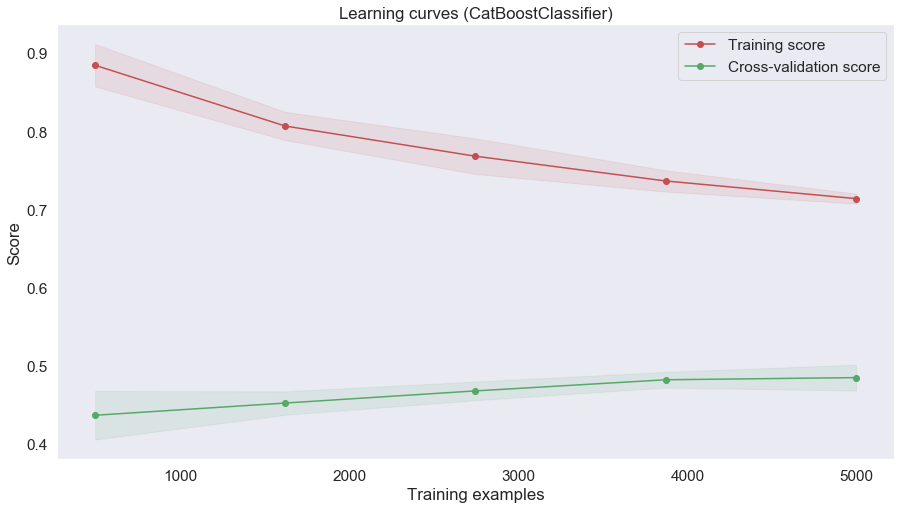

In [137]:
show_learning_curve_plot(final_model, X, y)

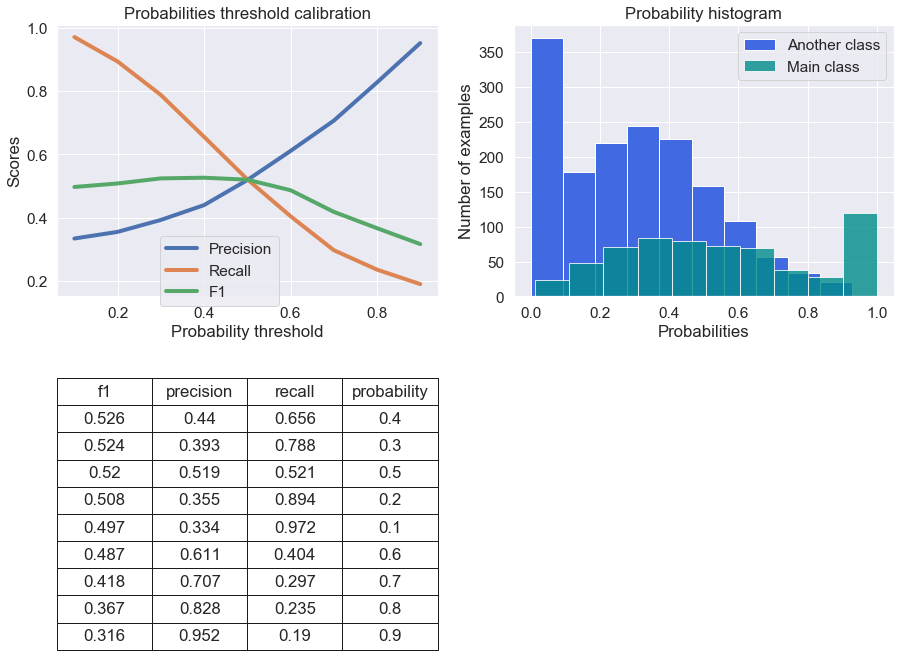

In [138]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

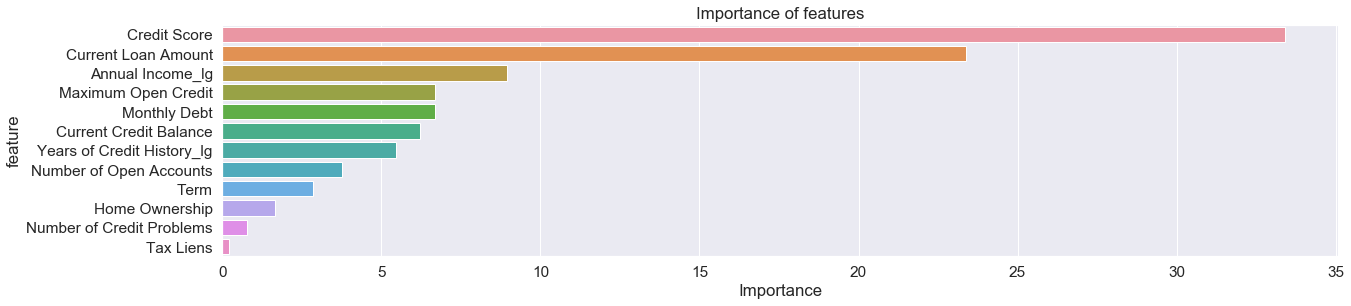

In [143]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [160]:
#important_features_top_back = important_features_top
# important_features_top = ['Home Ownership',
#  'Number of Open Accounts',
#  'Maximum Open Credit',
#  'Term',
#  'Current Loan Amount',
#  'Current Credit Balance',
#  'Monthly Debt',
#  'Credit Score',
#  'Annual Income_lg',
#  'Years of Credit History_lg']
important_features_top = important_features_top_back

In [161]:
important_features_top


['Credit Score',
 'Current Loan Amount',
 'Annual Income_lg',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Credit Balance',
 'Years of Credit History_lg',
 'Number of Open Accounts',
 'Term',
 'Home Ownership',
 'Number of Credit Problems',
 'Tax Liens']

### Финальная модель<a class="anchor" id="final_model"></a>


In [165]:
final_model = catb.CatBoostClassifier(n_estimators=5000, max_depth=3, l2_leaf_reg=10,
                                      class_weights=[1, 1.273],
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3767
           1       0.88      0.91      0.90      2960

    accuracy                           0.91      6727
   macro avg       0.90      0.91      0.91      6727
weighted avg       0.91      0.91      0.91      6727

TEST

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1616
           1       0.51      0.53      0.52       633

    accuracy                           0.72      2249
   macro avg       0.66      0.67      0.66      2249
weighted avg       0.73      0.72      0.73      2249

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1291  325
1                295  338


In [110]:
df_test_final = df_test.copy()
df_test_final[TARGET_NAME]=pd.Series(final_model.predict(df_test))

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Annual Income_lg,Years of Credit History_lg,Credit Default
count,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.314400,1.352445e+06,5.949876,0.035200,11.184400,18.325920,7.105704e+05,0.162000,15.614000,0.106800,1.227600,0.255600,1.215572e+07,2.963966e+05,18271.340000,1234.516860,14.012856,2.832532,0.314800
std,0.647858,6.990849e+05,3.573441,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.616348,0.356994,1.287968,0.436285,3.226097e+07,3.783020e+05,11543.881469,1551.352573,0.472356,0.393767,0.464529
min,0.000000,1.065330e+05,0.000000,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000,11.576210,1.360977,0.000000
25%,1.000000,9.365622e+05,3.000000,0.000000,8.000000,13.400000,2.785860e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,717.000000,13.749971,2.595255,0.000000
50%,1.000000,1.366922e+06,6.000000,0.000000,10.000000,17.000000,4.786760e+05,0.000000,0.000000,0.000000,1.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,738.000000,14.128072,2.833213,0.000000
75%,2.000000,1.486517e+06,10.000000,0.000000,14.000000,22.100000,8.025985e+05,0.000000,27.000000,0.000000,1.000000,1.000000,5.225825e+05,3.663485e+05,24146.000000,1234.516860,14.213431,3.095578,1.000000
max,3.000000,9.163985e+06,10.000000,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,13.000000,1.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000,16.521933,3.977811,1.000000


In [109]:
df_test_final.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Annual Income_lg,Years of Credit History_lg,Credit Default
0,2,1.366922e+06,4.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,1,0,162470.0,105906.0,6813.0,1234.51686,14.128072,2.525729,0
1,2,2.318380e+05,1.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,12,0,78298.0,46037.0,2318.0,699.00000,12.353794,3.487375,1
2,1,1.152540e+06,3.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,1,0,200178.0,146490.0,18729.0,7260.00000,13.957479,2.617396,1
3,1,1.220313e+06,10.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,1,0,217382.0,213199.0,27559.0,739.00000,14.014618,2.833213,0
4,1,2.340952e+06,6.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,1,1,777634.0,425391.0,42605.0,706.00000,14.666068,3.161247,0


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [144]:
# output
MODEL_FILE_PATH = '../DyachenkoDA_df_test_51_54_53-4200_5_1.273_21'
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

df_test_final.to_csv('DyachenkoDA_df_test_answer_51_54_53.csv', index=False, encoding='utf-8')